## Human Vs Model Grades Comparison

### Analysis plan

- Import data 
- EDA and Data Prep
- Check for consistency between human scores.
- Check for consistency between model scores. 
- Compare the model generated scores and human scores. 

The key evaluation metric used to evaluate whether the models agree with the human scores is the Quadratic Weighted Kappa. 
Quadratic Weighted Kappa (QWK), also known as Cohen's kappa, is a statistical measure used to evaluate the agreement between two raters 
who each classify items into mutually exclusive categories. This metric is especially common in scenarios where ratings are subjective, 
such as evaluating essay scoring. However, there are limitations with relying solely on QWK as a metric for assesing automated essay scoring,
therefore we will be using other supporting metrics such as pearsons and spearmans correlation coefficent and MAE and RMSE for assesing the automated
assesment scoring. (Doewes, Kurdhi, & Saxena, 2023)

:::{note}
Data only includes essay set 7. Narrative based essays.
:::

### Import the data

In [1]:
import pandas as pd

# Path to the CSV file
essay_path = 'essay-7-all.csv'
results_3_path = 'results-3.csv'
results_4_path = 'results-4.csv'

# Reading the CSV file into a DataFrame
essay_df = pd.read_csv(essay_path)
results_3_df = pd.read_csv(results_3_path)
results_4_df = pd.read_csv(results_4_path)


### Data Prep and EDA

In [2]:
# Removing columns where all values are null
essay_df = essay_df.dropna(axis=1, how='all')
results_3_df = results_3_df.dropna(axis=1, how='all')
results_4_df = results_4_df.dropna(axis=1, how='all')


In [3]:
print(essay_df.describe())

# Calculate the number of words in each essay
essay_df['word_count'] = essay_df['essay'].apply(lambda x: len(x.split()))

# Find the maximum number of words in any essay
max_word_count = essay_df['word_count'].max()

print(f"The maximum number of words in an essay is: {max_word_count}")

# Find the maximum number of words in any essay
avg_word_count = essay_df['word_count'].mean()

print(f"The average number of words in an essay is: {avg_word_count}")


           essay_id  essay_set  rater1_domain1  rater2_domain1  domain1_score  \
count   1569.000000     1569.0     1569.000000     1569.000000     1569.00000   
mean   18705.326960        7.0        8.023582        8.038878       16.06246   
std      498.542554        0.0        2.424120        2.517367        4.58535   
min    17834.000000        7.0        0.000000        0.000000        2.00000   
25%    18273.000000        7.0        6.000000        6.000000       13.00000   
50%    18712.000000        7.0        8.000000        8.000000       16.00000   
75%    19139.000000        7.0       10.000000       10.000000       19.00000   
max    19563.000000        7.0       12.000000       12.000000       24.00000   

       rater1_trait1  rater1_trait2  rater1_trait3  rater1_trait4  \
count    1569.000000    1569.000000    1569.000000    1569.000000   
mean        1.837476       2.022945       1.992352       2.170809   
std         0.862911       0.717481       0.613365       0.6889

In [4]:
# Calculating the sum of the 'error_count' column
error_count_sum_3 = results_3_df['error_count'].sum()
error_count_sum_4 = results_4_df['error_count'].sum()

# Printing the sum of the 'error_count' column
print("Total error count for model 1:", error_count_sum_3)
print("Total error count for model 2:", error_count_sum_4)

# Remove the error records from both datasets
# Filtering out rows where 'error_count' is greater than 0
results_3_df = results_3_df[results_3_df['error_count'] == 0]
results_4_df = results_4_df[results_4_df['error_count'] == 0]

# Printing the shape of the cleaned dataframes
print("Cleaned data for model 1:", results_3_df.shape)
print("Cleaned data for model 2:", results_4_df.shape)


Total error count for model 1: 25
Total error count for model 2: 2
Cleaned data for model 1: (1544, 21)
Cleaned data for model 2: (1567, 21)


#### Create Combined Data Frame. 

In [5]:
# Checking the uniqueness of essay_id in each dataframe
if (essay_df['essay_id'].nunique() == len(essay_df) and 
    results_3_df['essay_id'].nunique() == len(results_3_df) and
    results_4_df['essay_id'].nunique() == len(results_4_df)):
    
    # Selecting and renaming the necessary columns from essay_df, and making a copy
    essay_columns = essay_df[['essay_id', 'essay', 'rater1_trait1', 'rater1_trait2', 'rater1_trait3', 'rater1_trait4', 'rater1_domain1', 'rater2_trait1', 'rater2_trait2', 'rater2_trait3', 'rater2_trait4', 'rater2_domain1']].copy()
    essay_columns.rename(columns={'rater1_domain1': 'rater1_total', 'rater2_domain1': 'rater2_total'}, inplace=True)

    # Selecting, renaming, and calculating the total score for results_3_df, and making a copy
    results_3_columns = results_3_df[['essay_id', 'model', 'autoscore_trait1', 'autoscore_trait2', 'autoscore_trait3', 'autoscore_trait4']].copy()
    results_3_columns.rename(columns={
        'model': 'model_1_name',
        'autoscore_trait1': 'model_1_trait1',
        'autoscore_trait2': 'model_1_trait2',
        'autoscore_trait3': 'model_1_trait3',
        'autoscore_trait4': 'model_1_trait4'
    }, inplace=True)
    results_3_columns['model_1_total_score'] = results_3_columns.loc[:, ['model_1_trait1', 'model_1_trait2', 'model_1_trait3', 'model_1_trait4']].sum(axis=1)

    # Selecting, renaming, and calculating the total score for results_4_df, and making a copy
    results_4_columns = results_4_df[['essay_id', 'model', 'autoscore_trait1', 'autoscore_trait2', 'autoscore_trait3', 'autoscore_trait4']].copy()
    results_4_columns.rename(columns={
        'model': 'model_2_name',
        'autoscore_trait1': 'model_2_trait1',
        'autoscore_trait2': 'model_2_trait2',
        'autoscore_trait3': 'model_2_trait3',
        'autoscore_trait4': 'model_2_trait4'
    }, inplace=True)
    results_4_columns['model_2_total_score'] = results_4_columns.loc[:, ['model_2_trait1', 'model_2_trait2', 'model_2_trait3', 'model_2_trait4']].sum(axis=1)

    # Merging the DataFrames on 'essay_id'
    merged_df = pd.merge(essay_columns, results_3_columns, on='essay_id', how='left')
    df = pd.merge(merged_df, results_4_columns, on='essay_id', how='left')

    # Remove all rows with any missing values
    df = df.dropna()

    # Displaying the shape of the cleaned DataFrame
    print("Shape of the combined DataFrame:", df.shape)
else:
    print("Data integrity check failed: duplicate essay_id found in one or more DataFrames.")

Shape of the combined DataFrame: (1542, 24)


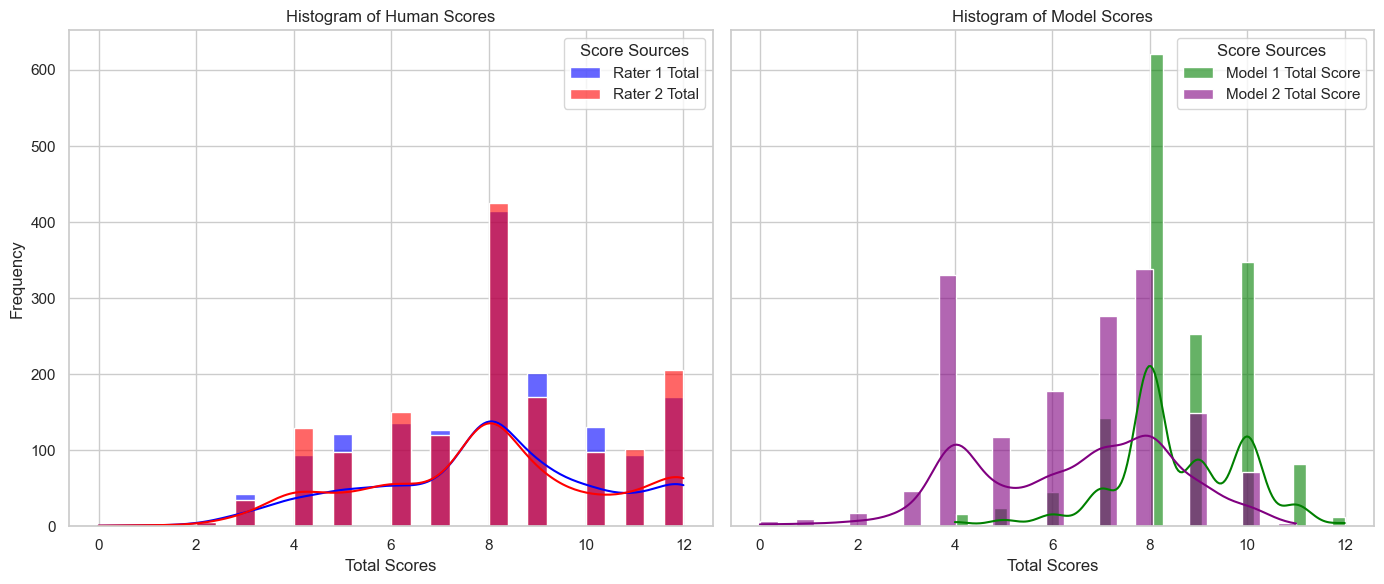

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

# Initialize a matplotlib figure with two subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)  # sharey ensures both plots use the same y-axis scale

# Plotting the histogram for human total scores on the first subplot
sns.histplot(df['rater1_total'], color="blue", label='Rater 1 Total', kde=True, alpha=0.6, bins=30, ax=axes[0])
sns.histplot(df['rater2_total'], color="red", label='Rater 2 Total', kde=True, alpha=0.6, bins=30, ax=axes[0])
axes[0].set_title('Histogram of Human Scores')
axes[0].set_xlabel('Total Scores')
axes[0].set_ylabel('Frequency')
axes[0].legend(title='Score Sources')

# Plotting the histogram for model total scores on the second subplot
sns.histplot(df['model_1_total_score'], color="green", label='Model 1 Total Score', kde=True, alpha=0.6, bins=30, ax=axes[1])
sns.histplot(df['model_2_total_score'], color="purple", label='Model 2 Total Score', kde=True, alpha=0.6, bins=30, ax=axes[1])
axes[1].set_title('Histogram of Model Scores')
axes[1].set_xlabel('Total Scores')
axes[1].set_ylabel('Frequency')
axes[1].legend(title='Score Sources')

# Adjust layout to prevent overlap and ensure clear readability
plt.tight_layout()

# Display the plot
plt.show()


### Human Raters Consistency Analysis

#### Objective
To assess the consistency between two human raters, ensuring their reliability before comparing their scores with model results.

#### Key Findings

- **Central Tendency**: Both raters show nearly identical mean scores.
- **Variability**: Standard deviations are close (Rater 1: 2.43, Rater 2: 2.51), indicating similar variability in their ratings.

#### Correlation Metrics
- **Pearson Correlation Coefficient**: 0.725 (P-value: extremely low), suggesting a strong positive linear relationship.
- **Spearman Correlation Coefficient**: 0.711 (P-value: extremely low), indicating consistent scoring patterns across the scoring range.

#### Quadratic Weighted Kappa
- **Quadratic Weighted Kappa**: 0.724, indicating substantial agreement between the raters, adjusted for chance. This value is close to the threshold of excellent agreement, suggesting that the raters' assessments are reliable and consistent.

#### Visual Analysis
- **Figure 1**: Boxplot shows identical distributions for different traits across raters.
- **Figure 2**: Scatterplot with frequency scaling highlights common agreement points with larger dots representing more frequent score pairs, though some slight disagreement is observed.
- **Figure 3**: Boxplot of total scores demonstrates similar score distributions, reinforcing rater consistency.

#### Conclusion
The correlation metrics and Quadratic Weighted Kappa of 0.724 confirm substantial agreement between the human raters. This level of consistency, supported by both statistical and visual analyses, validates the reliability of the raters' scores for use in further comparative evaluations with automated assessment models.


In [7]:
from scipy import stats

# Basic Statistics
mean_rater1 = df['rater1_total'].mean()

mean_rater2 = df['rater2_total'].mean()


# Additional Statistics
std_dev_rater1 = df['rater1_total'].std()
variance_rater1 = df['rater1_total'].var()
iqr_rater1 = df['rater1_total'].quantile(0.75) - df['rater1_total'].quantile(0.25)

std_dev_rater2 = df['rater2_total'].std()
variance_rater2 = df['rater2_total'].var()
iqr_rater2 = df['rater2_total'].quantile(0.75) - df['rater2_total'].quantile(0.25)

# Creating a DataFrame for the results
stats_df = pd.DataFrame({
    'Statistic': ['Mean', 'Standard Deviation', 'Variance',  'Interquartile Range'],
    'Rater 1 Total': [mean_rater1, std_dev_rater1, variance_rater1, iqr_rater1],
    'Rater 2 Total': [mean_rater2, std_dev_rater2, variance_rater2, iqr_rater2]
})

# Printing the results in a tabular format
print("Summary of Rater Scores:")
print(stats_df.to_string(index=False))

Summary of Rater Scores:
          Statistic  Rater 1 Total  Rater 2 Total
               Mean       8.003891       8.018807
 Standard Deviation       2.426329       2.514907
           Variance       5.887071       6.324760
Interquartile Range       4.000000       4.000000


In [8]:
import pingouin as pg
from sklearn.metrics import cohen_kappa_score

# Pearson Correlation - Measures linear correlation
pearson_corr, p_value_pearson = stats.pearsonr(df['rater1_total'], df['rater2_total'])
print(f"Pearson Correlation Coefficient: {pearson_corr}, P-value: {p_value_pearson}")

# Spearman Correlation - Measures monotonic relationship
spearman_corr, p_value_spearman = stats.spearmanr(df['rater1_total'], df['rater2_total'])
print(f"Spearman Rank Correlation Coefficient: {spearman_corr}, P-value: {p_value_spearman}")

# Calculating the Quadratic Weighted Kappa
qwk_score = cohen_kappa_score(df['rater1_total'], df['rater2_total'], weights='quadratic')
print(f"Quadratic Weighted Kappa: {qwk_score}")


Pearson Correlation Coefficient: 0.7246372298038762, P-value: 2.7041333100701165e-251
Spearman Rank Correlation Coefficient: 0.7107944878198085, P-value: 1.404379032099486e-237
Quadratic Weighted Kappa: 0.7241584434783956


/var/folders/mp/xnyk4rhx3jdf4kjnnhwggjwr0000gn/T/ipykernel_9262/1251333834.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Rater and Trait', bbox_to_anchor=(1.05, 1), loc='upper left')


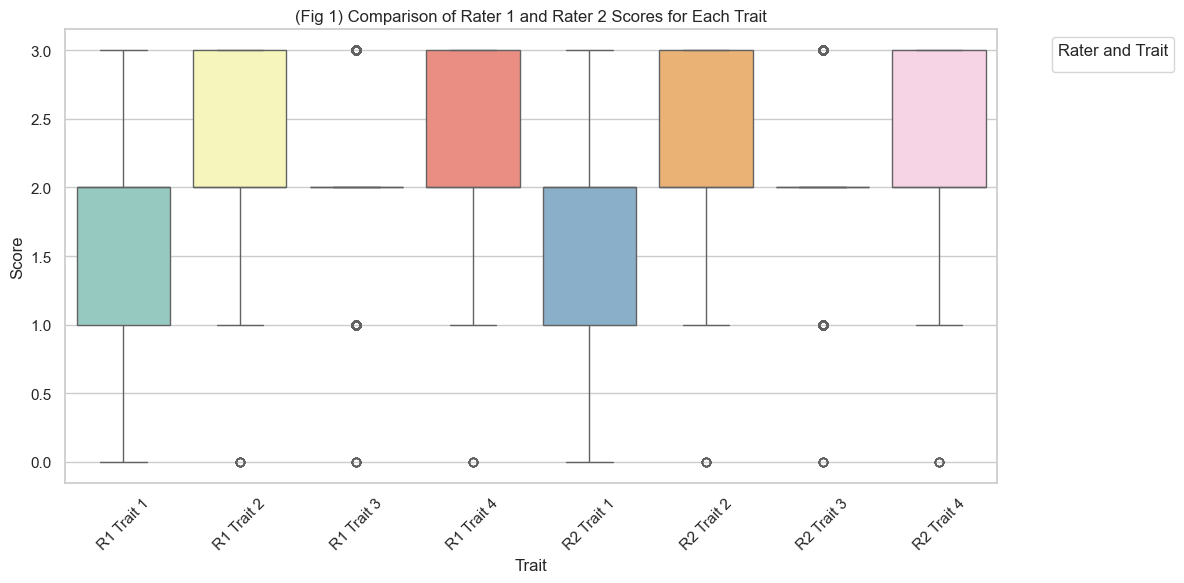

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt


# Creating a new DataFrame that stacks the data for easier comparison in boxplots
# This involves melting the DataFrame so that we can use seaborn's boxplot to compare distributions side-by-side.
melted_data = df[['rater1_trait1', 'rater1_trait2', 'rater1_trait3', 'rater1_trait4',
                  'rater2_trait1', 'rater2_trait2', 'rater2_trait3', 'rater2_trait4']].copy()

# Rename columns to a simpler form
melted_data.columns = ['R1 Trait 1', 'R1 Trait 2', 'R1 Trait 3', 'R1 Trait 4',
                       'R2 Trait 1', 'R2 Trait 2', 'R2 Trait 3', 'R2 Trait 4']

# Melting the DataFrame
melted_data = pd.melt(melted_data, var_name='Trait', value_name='Score')

# Creating the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Trait', y='Score', hue='Trait', data=melted_data, palette='Set3')
plt.title('(Fig 1) Comparison of Rater 1 and Rater 2 Scores for Each Trait')
plt.xticks(rotation=45)
plt.legend(title='Rater and Trait', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

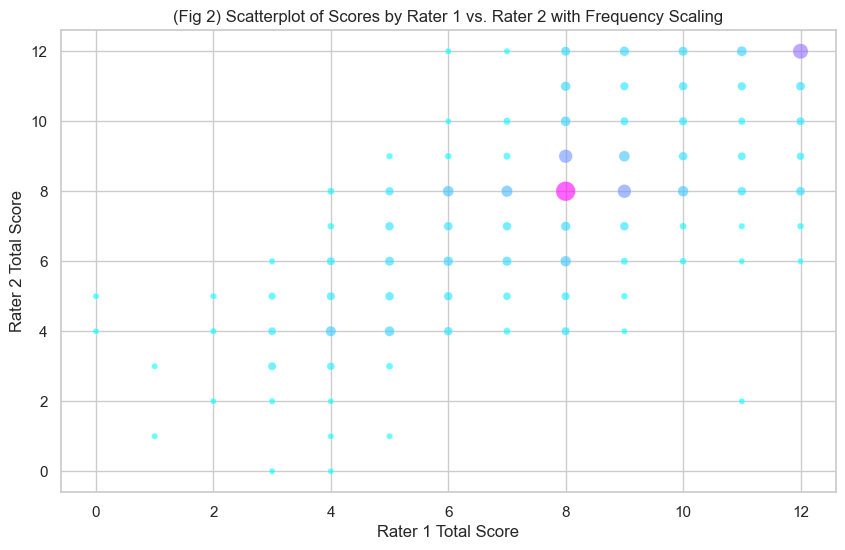

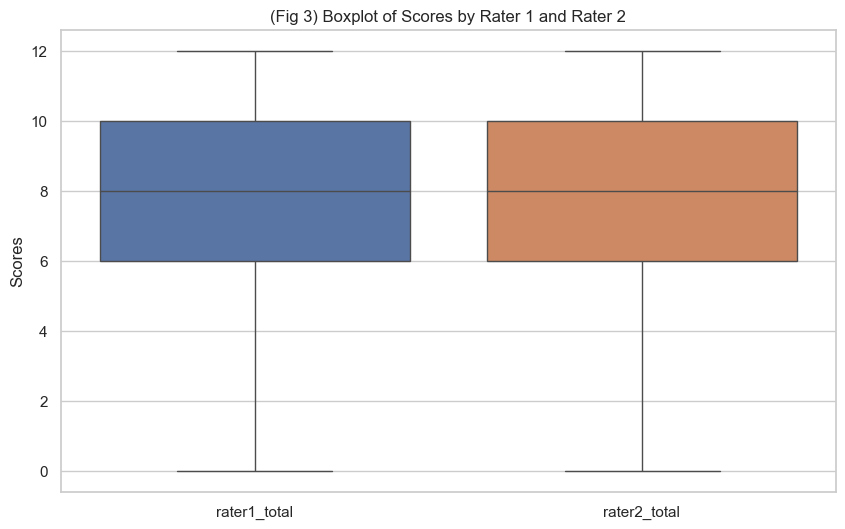

In [10]:

# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

# Calculate frequencies of each (Rater1, Rater2) pair
frequency = df.groupby(['rater1_total', 'rater2_total']).size().reset_index(name='Frequency')

# Create a new column for point sizes, adjusted for better visibility
frequency['sizes'] = frequency['Frequency'] * 10  # Scale factor for size, adjust as needed for visibility

# Scatterplot to visualize the relationship between rater1_total and rater2_total with frequency sizing
plt.figure(figsize=(10, 6))
sns.scatterplot(data=frequency, x='rater1_total', y='rater2_total', size='sizes', sizes=(20, 200),  # min and max size of points
                alpha=0.6, legend=None, hue='Frequency', palette='cool')  # No legend for sizes, color by frequency

# Adding titles and labels
plt.title('(Fig 2) Scatterplot of Scores by Rater 1 vs. Rater 2 with Frequency Scaling')
plt.xlabel('Rater 1 Total Score')
plt.ylabel('Rater 2 Total Score')

# Show plot
plt.show()

# Boxplot to compare distributions of scores from different raters
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['rater1_total', 'rater2_total']])
plt.title('(Fig 3) Boxplot of Scores by Rater 1 and Rater 2')
plt.ylabel('Scores')
plt.show()

### Model Scores Consistency Analysis

#### Objective
To assess the reliability and consistency of two automated models, comparing their performance in scoring to identify any discrepancies before utilizing their outputs in conjunction with human raters.

#### Key Findings

- **Central Tendency**:
  - **Model 1 Mean**: 8.566148
  - **Model 2 Mean**: 6.410506
  - The models show significant differences in their average scores, with Model 1 consistently scoring higher than Model 2.

- **Variability**:
  - **Standard Deviation**: Model 1 has a standard deviation of 1.364887, while Model 2's is higher at 2.060907, indicating that Model 2 scores are more spread out.
  - **Variance**: The variance for Model 2 (4.247339) is more than double that of Model 1 (1.862916), further indicating greater inconsistency in Model 2's scoring pattern.
  - **Interquartile Range**: Model 2 also exhibits a larger interquartile range (4), suggesting a broader spread of scores within the middle 50% compared to Model 1 (2).

#### Correlation Metrics
- **Pearson Correlation Coefficient**: 0.5586628582731928 (P-value: extremely low), suggesting only a moderate positive linear relationship, which points to inconsistencies in how models correlate with each other.
- **Spearman Rank Correlation Coefficient**: 0.5442678883613659 (P-value: extremely low), which underscores the non-linear inconsistencies between the models' scoring trends.

#### Visual Analysis
- **Figure 4**: The comparison of trait scores in the boxplot reveals distinct differences between the models, with Model 1 showing more uniform scores across traits than Model 2.
- **Figure 5**: Scatterplot with frequency scaling illustrates that while there are common score pairings between the models, there are also visible areas where the scores diverge significantly.
- **Figure 6**: The boxplot of total scores clearly highlights the different scoring distributions between the models, with Model 1 showing tighter score clustering compared to the broader spread in Model 2's scores.

#### Conclusion
The statistical analysis and visual inspections reveal notable discrepancies in scoring between the two models. Despite some moderate correlation, the considerable differences in mean scores, variability, and visual evidence from the plots suggest that the models are not consistent with each other. 
Such variations underscore the need to treat these models as seperate when comparing them with human scores. 


In [11]:
# Calculate basic statistics for the model scores
mean_model1 = df['model_1_total_score'].mean()
mean_model2 = df['model_2_total_score'].mean()

# Calculate additional statistics for variability
std_dev_model1 = df['model_1_total_score'].std()
variance_model1 = df['model_1_total_score'].var()
iqr_model1 = df['model_1_total_score'].quantile(0.75) - df['model_1_total_score'].quantile(0.25)

std_dev_model2 = df['model_2_total_score'].std()
variance_model2 = df['model_2_total_score'].var()
iqr_model2 = df['model_2_total_score'].quantile(0.75) - df['model_2_total_score'].quantile(0.25)

# Create a DataFrame for the results
stats_df = pd.DataFrame({
    'Statistic': ['Mean', 'Standard Deviation', 'Variance', 'Interquartile Range'],
    'Model 1 Total': [mean_model1, std_dev_model1, variance_model1, iqr_model1],
    'Model 2 Total': [mean_model2, std_dev_model2, variance_model2, iqr_model2]
})

# Print the results in a tabular format
print("Summary of Model Scores:")
print(stats_df.to_string(index=False))

# Calculate and print Pearson and Spearman correlation coefficients for the model scores
pearson_corr, p_value_pearson = stats.pearsonr(df['model_1_total_score'], df['model_2_total_score'])
print(f"Pearson Correlation Coefficient: {pearson_corr}, P-value: {p_value_pearson}")

spearman_corr, p_value_spearman = stats.spearmanr(df['model_1_total_score'], df['model_2_total_score'])
print(f"Spearman Rank Correlation Coefficient: {spearman_corr}, P-value: {p_value_spearman}")

Summary of Model Scores:
          Statistic  Model 1 Total  Model 2 Total
               Mean       8.566148       6.410506
 Standard Deviation       1.364887       2.060907
           Variance       1.862916       4.247339
Interquartile Range       2.000000       4.000000
Pearson Correlation Coefficient: 0.5586628582731928, P-value: 2.836564217783995e-127
Spearman Rank Correlation Coefficient: 0.5442678883613659, P-value: 1.2430225610008384e-119


/var/folders/mp/xnyk4rhx3jdf4kjnnhwggjwr0000gn/T/ipykernel_9262/197201416.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Model and Trait', bbox_to_anchor=(1.05, 1), loc='upper left')


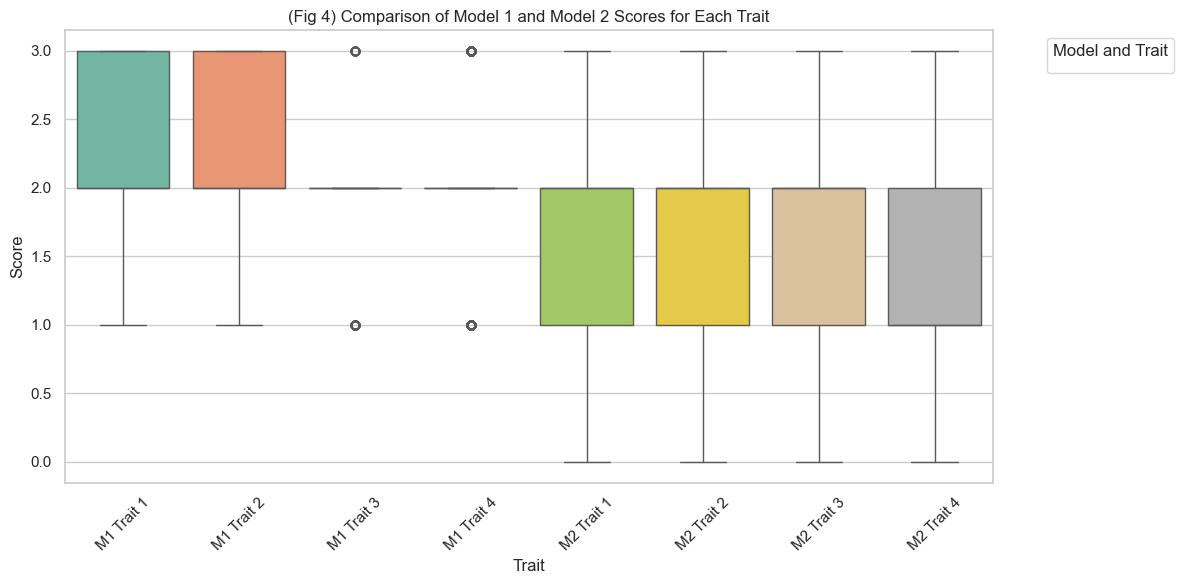

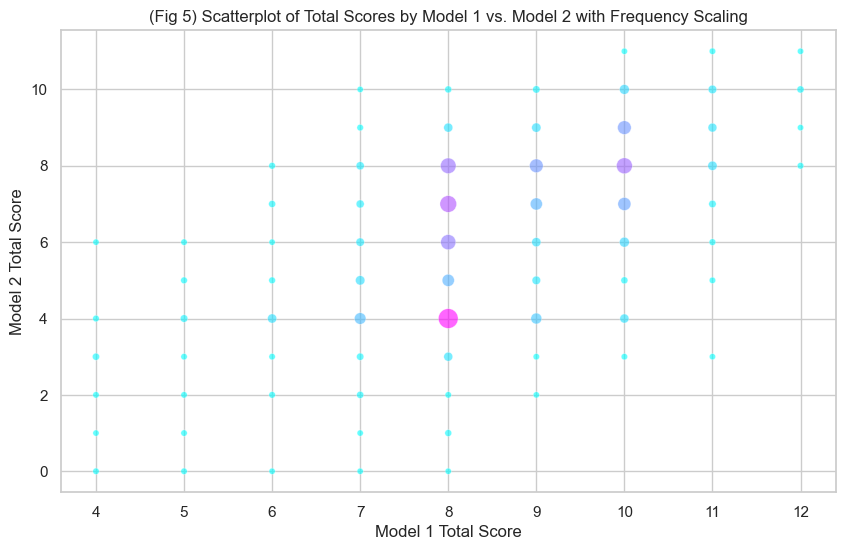

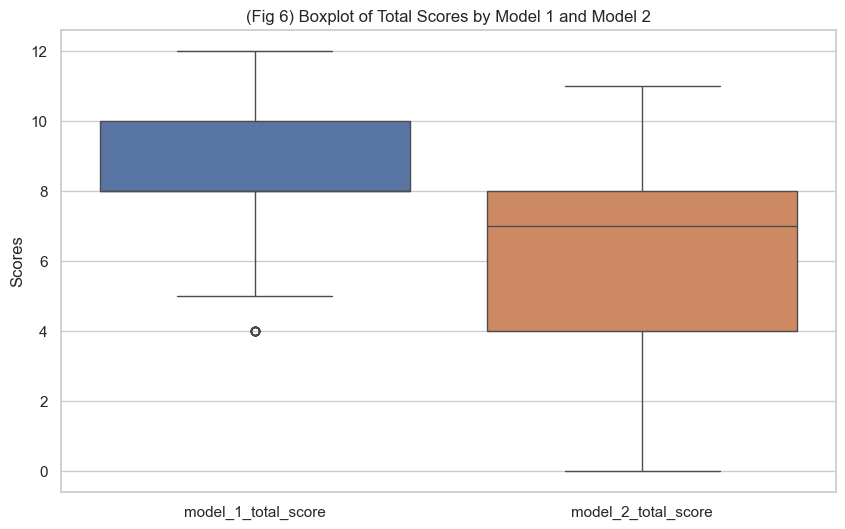

In [12]:
# Prepare DataFrame for boxplots and scatter plots by melting
model_data = df[['model_1_trait1', 'model_1_trait2', 'model_1_trait3', 'model_1_trait4',
                 'model_2_trait1', 'model_2_trait2', 'model_2_trait3', 'model_2_trait4']].copy()
model_data.columns = ['M1 Trait 1', 'M1 Trait 2', 'M1 Trait 3', 'M1 Trait 4',
                      'M2 Trait 1', 'M2 Trait 2', 'M2 Trait 3', 'M2 Trait 4']
model_data_melted = pd.melt(model_data, var_name='Trait', value_name='Score')

# Boxplot for model traits
plt.figure(figsize=(12, 6))
sns.boxplot(x='Trait', y='Score', hue='Trait', data=model_data_melted, palette='Set2')
plt.title('(Fig 4) Comparison of Model 1 and Model 2 Scores for Each Trait')
plt.xticks(rotation=45)
plt.legend(title='Model and Trait', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Calculate frequencies of each (Model1, Model2) total score pair
frequency = df.groupby(['model_1_total_score', 'model_2_total_score']).size().reset_index(name='Frequency')
frequency['sizes'] = frequency['Frequency'] * 10  # Adjusting size for better visibility

# Scatterplot with frequency scaling for model total scores
plt.figure(figsize=(10, 6))
sns.scatterplot(data=frequency, x='model_1_total_score', y='model_2_total_score', size='sizes', sizes=(20, 200),
                alpha=0.6, legend=None, hue='Frequency', palette='cool')
plt.title('(Fig 5) Scatterplot of Total Scores by Model 1 vs. Model 2 with Frequency Scaling')
plt.xlabel('Model 1 Total Score')
plt.ylabel('Model 2 Total Score')
plt.show()

# Boxplot to compare distributions of total scores from both models
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['model_1_total_score', 'model_2_total_score']])
plt.title('(Fig 6) Boxplot of Total Scores by Model 1 and Model 2')
plt.ylabel('Scores')
plt.show()

### Comparing Human-Rated Scores Versus Model Scores

Our analysis has shown that human-rated scores exhibit enough consistency to be combined into a single comprehensive score. In contrast, model-generated scores vary significantly, necessitating a separate evaluation against the unified human scores. This section outlines our approach to comparing these model scores with the consolidated human ratings.

#### Analysis Plan
1. **Consolidation of Human Scores**: To establish a clear baseline for comparisons, we will average the scores from multiple human raters into a single score per trait and overall. This unified score will serve as the standard against which we measure each model's performance.
   
2. **Selection of Evaluation Metrics**: We will use Mean Absolute Error (MAE) and Root Mean Square Error (RMSE) to quantify the accuracy and consistency of the models relative to human scores. Additionally, Pearson and Spearman correlation coefficients will assess the strength and direction of the relationships between model predictions and human judgments.

3. **Purpose of Metrics**:
   - **MAE/RMSE**: Evaluate the average magnitude and distribution of errors between model predictions and human scores.
   - **Correlation Coefficients**: Determine how well model scores align with human ratings in terms of linear and rank-order relationships.

#### Objective
This structured approach allows us to critically assess which model more accurately mirrors human assessment, guiding further improvements and ensuring the reliability of automated scoring systems in practical applications.


In [13]:
import numpy as np

# Calculate the whole number average of human rater scores for each trait and create new columns
df['human_avg_trait1'] = np.round(df[['rater1_trait1', 'rater2_trait1']].mean(axis=1))
df['human_avg_trait2'] = np.round(df[['rater1_trait2', 'rater2_trait2']].mean(axis=1))
df['human_avg_trait3'] = np.round(df[['rater1_trait3', 'rater2_trait3']].mean(axis=1))
df['human_avg_trait4'] = np.round(df[['rater1_trait4', 'rater2_trait4']].mean(axis=1))

# Calculate the overall whole number average score combining all traits from both raters
df['human_avg_score'] = np.round(df[['rater1_total', 'rater2_total']].mean(axis=1))


# Note on scoring:
# This approach of averaging and rounding might still favor the higher marker, especially noticeable with only two raters.
# Ideally, having an odd number of raters, such as three, could help mitigate this bias, as it allows for a median value that might better represent a consensus score.


### Evaluation of Model 1 Performance Against Human Scores

#### Overview
The analysis assesses Model 1's ability to approximate human average scores across four traits and overall performance. Metrics used include Mean Absolute Error (MAE), Root Mean Square Error (RMSE), Pearson and Spearman correlation coefficients, and Quadratic Weighted Kappa (QWK).

#### Error Metrics
- **Traits 1-4**: MAE values range from 0.229 to 0.641, and RMSE values from 0.500 to 0.946. Lower values in Traits 3 and 4 suggest better model performance on these specific aspects.
- **Total Scores**: MAE of 1.760 and RMSE of 2.247 indicate more significant discrepancies in the model's overall scoring capability compared to individual traits.

#### Correlation Analysis
- **Traits 1-4**: Pearson and Spearman correlations range from weak to moderate (0.148 to 0.355). Higher values in Traits 1 and 3 suggest these are better modeled.
- **Total**: Pearson correlation of 0.402 and Spearman correlation of 0.378 indicate a moderate relationship overall, suggesting some alignment with human scoring.

#### Quadratic Weighted Kappa Analysis
- **Traits 1-4**: QWK scores range from 0.158 to 0.259, indicating poor to fair agreement between Model 1's scores and human scores, reflecting inconsistency across traits.
- **Total**: QWK of 0.336 for the total scores suggests a fair level of agreement, pointing to some capacity of the model to replicate human scoring, yet underscoring the necessity for improvement.

#### Conclusion
While Model 1 shows moderate success in approximating human scores on specific traits, the overall performance (considering total scores) reveals significant room for improvement. The model effectively mirrors human ratings in some aspects but fails to consistently replicate the human scoring pattern across all evaluated areas, as also highlighted by the generally low Quadratic Weighted Kappa scores. This comprehensive analysis underscores the need for model refinement to enhance accuracy, consistency in scoring, and agreement with human raters.


In [14]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, cohen_kappa_score
from scipy.stats import pearsonr, spearmanr


# Calculate MAE, RMSE, and QWK for each trait
mae_trait1 = mean_absolute_error(df['human_avg_trait1'], df['model_1_trait1'])
rmse_trait1 = np.sqrt(mean_squared_error(df['human_avg_trait1'], df['model_1_trait1']))
qwk_trait1 = cohen_kappa_score(df['human_avg_trait1'].astype(int), df['model_1_trait1'].astype(int), weights='quadratic')

mae_trait2 = mean_absolute_error(df['human_avg_trait2'], df['model_1_trait2'])
rmse_trait2 = np.sqrt(mean_squared_error(df['human_avg_trait2'], df['model_1_trait2']))
qwk_trait2 = cohen_kappa_score(df['human_avg_trait2'].astype(int), df['model_1_trait2'].astype(int), weights='quadratic')

mae_trait3 = mean_absolute_error(df['human_avg_trait3'], df['model_1_trait3'])
rmse_trait3 = np.sqrt(mean_squared_error(df['human_avg_trait3'], df['model_1_trait3']))
qwk_trait3 = cohen_kappa_score(df['human_avg_trait3'].astype(int), df['model_1_trait3'].astype(int), weights='quadratic')

mae_trait4 = mean_absolute_error(df['human_avg_trait4'], df['model_1_trait4'])
rmse_trait4 = np.sqrt(mean_squared_error(df['human_avg_trait4'], df['model_1_trait4']))
qwk_trait4 = cohen_kappa_score(df['human_avg_trait4'].astype(int), df['model_1_trait4'].astype(int), weights='quadratic')

# Calculate MAE, RMSE, and QWK for total scores
mae_total = mean_absolute_error(df['human_avg_score'], df['model_1_total_score'])
rmse_total = np.sqrt(mean_squared_error(df['human_avg_score'], df['model_1_total_score']))
qwk_total = cohen_kappa_score(df['human_avg_score'].astype(int), df['model_1_total_score'].astype(int), weights='quadratic')

# Calculate Pearson and Spearman correlations for each trait
pearson_corr_trait1, p_pearson_trait1 = pearsonr(df['human_avg_trait1'], df['model_1_trait1'])
spearman_corr_trait1, p_spearman_trait1 = spearmanr(df['human_avg_trait1'], df['model_1_trait1'])

pearson_corr_trait2, p_pearson_trait2 = pearsonr(df['human_avg_trait2'], df['model_1_trait2'])
spearman_corr_trait2, p_spearman_trait2 = spearmanr(df['human_avg_trait2'], df['model_1_trait2'])

pearson_corr_trait3, p_pearson_trait3 = pearsonr(df['human_avg_trait3'], df['model_1_trait3'])
spearman_corr_trait3, p_spearman_trait3 = spearmanr(df['human_avg_trait3'], df['model_1_trait3'])

pearson_corr_trait4, p_pearson_trait4 = pearsonr(df['human_avg_trait4'], df['model_1_trait4'])
spearman_corr_trait4, p_spearman_trait4 = spearmanr(df['human_avg_trait4'], df['model_1_trait4'])

pearson_corr_total, p_pearson_total = pearsonr(df['human_avg_score'], df['model_1_total_score'])
spearman_corr_total, p_spearman_total = spearmanr(df['human_avg_score'], df['model_1_total_score'])

# Display the errors, correlations, and QWK for each trait and total scores
print("Metrics for each trait and total scores:")
print(f"Trait 1 - MAE: {mae_trait1}, RMSE: {rmse_trait1}, QWK: {qwk_trait1}, Pearson: {pearson_corr_trait1} (p={p_pearson_trait1}), Spearman: {spearman_corr_trait1} (p={p_spearman_trait1})")
print(f"Trait 2 - MAE: {mae_trait2}, RMSE: {rmse_trait2}, QWK: {qwk_trait2}, Pearson: {pearson_corr_trait2} (p={p_pearson_trait2}), Spearman: {spearman_corr_trait2} (p={p_spearman_trait2})")
print(f"Trait 3 - MAE: {mae_trait3}, RMSE: {rmse_trait3}, QWK: {qwk_trait3}, Pearson: {pearson_corr_trait3} (p={p_pearson_trait3}), Spearman: {spearman_corr_trait3} (p={p_spearman_trait3})")
print(f"Trait 4 - MAE: {mae_trait4}, RMSE: {rmse_trait4}, QWK: {qwk_trait4}, Pearson: {pearson_corr_trait4} (p={p_pearson_trait4}), Spearman: {spearman_corr_trait4} (p={p_spearman_trait4})")
print(f"Total - MAE: {mae_total}, RMSE: {rmse_total}, QWK: {qwk_total}, Pearson: {pearson_corr_total} (p={p_pearson_total}), Spearman: {spearman_corr_total} (p={p_spearman_total})")


Metrics for each trait and total scores:
Trait 1 - MAE: 0.6413748378728924, RMSE: 0.946356245116951, QWK: 0.25007025632465396, Pearson: 0.35483932955723874 (p=5.675670909719326e-47), Spearman: 0.3493019539635336 (p=1.7748699164966692e-45)
Trait 2 - MAE: 0.46108949416342415, RMSE: 0.7071067811865476, QWK: 0.2592072419211928, Pearson: 0.29335766093601645 (p=5.557219175747727e-32), Spearman: 0.2809526002238581 (p=2.2908464975307327e-29)
Trait 3 - MAE: 0.22892347600518806, RMSE: 0.49967564057565905, QWK: 0.23264543247791658, Pearson: 0.26180919491773247 (p=1.3847248742189622e-25), Spearman: 0.25638580840370306 (p=1.4379143154849911e-24)
Trait 4 - MAE: 0.43320363164721143, RMSE: 0.6927454356768455, QWK: 0.15871396215731604, Pearson: 0.16217645549192397 (p=1.4970074323522732e-10), Spearman: 0.14836829935361628 (p=4.802524908037326e-09)
Total - MAE: 1.7600518806744487, RMSE: 2.246773158079184, QWK: 0.3358319878911866, Pearson: 0.4020264704585714 (p=5.620807700333056e-61), Spearman: 0.37779204

### Evaluation of Model 2 Performance Against Human Scores
#### Error Metrics
- **Traits 1-4**: MAE values ranging from 0.489 to 0.802 and RMSE values from 0.750 to 1.023 indicate noticeable discrepancies in Model 2’s predictions compared to human scores, with particularly poor performance on Trait 4.
- **Total Scores**: The high MAE of 2.162 and RMSE of 2.825 highlight significant deviations in the model’s ability to consistently align with overall human scoring.

#### Correlation Analysis
- **Traits 1-4**: With Pearson and Spearman correlations between 0.251 and 0.349, the model shows only a limited ability to mimic human scoring patterns, suggesting substantial misalignment in rank and linear relationships.
- **Total**: Pearson and Spearman correlations of approximately 0.437 and 0.430 respectively, while moderate, still reflect significant inconsistencies and reveal that the model frequently fails to capture the nuances of human scoring.

#### Quadratic Weighted Kappa Analysis
- **Traits 1-4**: QWK scores from 0.136 to 0.323 reveal a generally poor agreement with human scores, with Traits 3 and 4 being particularly problematic. These scores suggest the model often misinterprets the criteria or severity ascribed by human raters.
- **Total**: A QWK of 0.344, while indicating some degree of agreement, is far from demonstrating a robust alignment with human raters, pointing to a model that often misses the mark in understanding and replicating the complexity of human scoring.

#### Conclusion
Despite modest correlations, Model 2’s performance in replicating human scoring patterns is underwhelming across individual traits and overall assessments. The analysis exposes significant shortcomings in the model's capability to match human scoring precision, especially in understanding the depth and subtlety of traits and overall scores. These results emphasize the need for substantial improvements and recalibration of Model 2 to enhance its accuracy, consistency, and reliability in practical scoring applications. Future refinements should focus on addressing the specific weaknesses in traits that show the poorest agreement and understanding human judgments more deeply.

In [15]:


# Calculate MAE, RMSE, and QWK for each trait
mae_trait1 = mean_absolute_error(df['human_avg_trait1'], df['model_2_trait1'])
rmse_trait1 = np.sqrt(mean_squared_error(df['human_avg_trait1'], df['model_2_trait1']))
qwk_trait1 = cohen_kappa_score(df['human_avg_trait1'].astype(int), df['model_2_trait1'].astype(int), weights='quadratic')

mae_trait2 = mean_absolute_error(df['human_avg_trait2'], df['model_2_trait2'])
rmse_trait2 = np.sqrt(mean_squared_error(df['human_avg_trait2'], df['model_2_trait2']))
qwk_trait2 = cohen_kappa_score(df['human_avg_trait2'].astype(int), df['model_2_trait2'].astype(int), weights='quadratic')

mae_trait3 = mean_absolute_error(df['human_avg_trait3'], df['model_2_trait3'])
rmse_trait3 = np.sqrt(mean_squared_error(df['human_avg_trait3'], df['model_2_trait3']))
qwk_trait3 = cohen_kappa_score(df['human_avg_trait3'].astype(int), df['model_2_trait3'].astype(int), weights='quadratic')

mae_trait4 = mean_absolute_error(df['human_avg_trait4'], df['model_2_trait4'])
rmse_trait4 = np.sqrt(mean_squared_error(df['human_avg_trait4'], df['model_2_trait4']))
qwk_trait4 = cohen_kappa_score(df['human_avg_trait4'].astype(int), df['model_2_trait4'].astype(int), weights='quadratic')

# Calculate MAE, RMSE, and QWK for total scores
mae_total = mean_absolute_error(df['human_avg_score'], df['model_2_total_score'])
rmse_total = np.sqrt(mean_squared_error(df['human_avg_score'], df['model_2_total_score']))
qwk_total = cohen_kappa_score(df['human_avg_score'].astype(int), df['model_2_total_score'].astype(int), weights='quadratic')

# Calculate Pearson and Spearman correlations for each trait
pearson_corr_trait1, p_pearson_trait1 = pearsonr(df['human_avg_trait1'], df['model_2_trait1'])
spearman_corr_trait1, p_spearman_trait1 = spearmanr(df['human_avg_trait1'], df['model_2_trait1'])

pearson_corr_trait2, p_pearson_trait2 = pearsonr(df['human_avg_trait2'], df['model_2_trait2'])
spearman_corr_trait2, p_spearman_trait2 = spearmanr(df['human_avg_trait2'], df['model_2_trait2'])

pearson_corr_trait3, p_pearson_trait3 = pearsonr(df['human_avg_trait3'], df['model_2_trait3'])
spearman_corr_trait3, p_spearman_trait3 = spearmanr(df['human_avg_trait3'], df['model_2_trait3'])

pearson_corr_trait4, p_pearson_trait4 = pearsonr(df['human_avg_trait4'], df['model_2_trait4'])
spearman_corr_trait4, p_spearman_trait4 = spearmanr(df['human_avg_trait4'], df['model_2_trait4'])

pearson_corr_total, p_pearson_total = pearsonr(df['human_avg_score'], df['model_2_total_score'])
spearman_corr_total, p_spearman_total = spearmanr(df['human_avg_score'], df['model_2_total_score'])

# Display the errors, correlations, and QWK for each trait and total scores
print("Metrics for each trait and total scores:")
print(f"Trait 1 - MAE: {mae_trait1}, RMSE: {rmse_trait1}, QWK: {qwk_trait1}, Pearson: {pearson_corr_trait1} (p={p_pearson_trait1}), Spearman: {spearman_corr_trait1} (p={p_spearman_trait1})")
print(f"Trait 2 - MAE: {mae_trait2}, RMSE: {rmse_trait2}, QWK: {qwk_trait2}, Pearson: {pearson_corr_trait2} (p={p_pearson_trait2}), Spearman: {spearman_corr_trait2} (p={p_spearman_trait2})")
print(f"Trait 3 - MAE: {mae_trait3}, RMSE: {rmse_trait3}, QWK: {qwk_trait3}, Pearson: {pearson_corr_trait3} (p={p_pearson_trait3}), Spearman: {spearman_corr_trait3} (p={p_spearman_trait3})")
print(f"Trait 4 - MAE: {mae_trait4}, RMSE: {rmse_trait4}, QWK: {qwk_trait4}, Pearson: {pearson_corr_trait4} (p={p_pearson_trait4}), Spearman: {spearman_corr_trait4} (p={p_spearman_trait4})")
print(f"Total - MAE: {mae_total}, RMSE: {rmse_total}, QWK: {qwk_total}, Pearson: {pearson_corr_total} (p={p_pearson_total}), Spearman: {spearman_corr_total} (p={p_spearman_total})")


Metrics for each trait and total scores:
Trait 1 - MAE: 0.5376134889753567, RMSE: 0.8145085171522878, QWK: 0.31867337339749824, Pearson: 0.3384638131317651 (p=1.2297907107052097e-42), Spearman: 0.34697421650925736 (p=7.392288521495188e-45)
Trait 2 - MAE: 0.5363164721141375, RMSE: 0.7910819398382585, QWK: 0.3233354524147979, Pearson: 0.3493440890315951 (p=1.729427625149266e-45), Spearman: 0.34369350014856953 (p=5.40990719273753e-44)
Trait 3 - MAE: 0.4896238651102464, RMSE: 0.7498378553650925, QWK: 0.18681274565978234, Pearson: 0.25094128627430917 (p=1.425897933881876e-23), Spearman: 0.25146567554366195 (p=1.1459454494924987e-23)
Trait 4 - MAE: 0.8015564202334631, RMSE: 1.0230799611975063, QWK: 0.13594430688428794, Pearson: 0.25393610969555047 (p=4.064350979405521e-24), Spearman: 0.2514760957008236 (p=1.1409732359033798e-23)
Total - MAE: 2.1621271076523993, RMSE: 2.825444881926411, QWK: 0.34401758979281116, Pearson: 0.4367091951130355 (p=8.033603684084239e-73), Spearman: 0.43020800849005

### Comparative Analysis of Model 1 and Model 2 Performance

#### Overview
This section provides a detailed comparison between Model 1 and Model 2 in terms of their ability to mirror human scores. 


#### Error Metrics Comparison
- **MAE and RMSE**:
  - **Model 1** tends to show lower MAE and RMSE across individual traits, indicating more precise predictions that align closely with human assessments.
  - **Model 2** displays higher errors, particularly in total scores, suggesting less accuracy in capturing the overall human scoring pattern.

#### Correlation Analysis
- **Pearson and Spearman Correlations**:
  - Both models show moderate correlations with human scores. **Model 1** generally achieves slightly higher correlations across all traits and total scores, indicating more consistency.
  - **Model 2**, while showing decent correlations, lacks the stability of Model 1, with more variation in correlation values across different traits.

#### Quadratic Weighted Kappa (QWK) Analysis
- **QWK Scores**:
  - **Model 1** achieves a higher QWK in most traits and overall scores compared to Model 2, indicating a better agreement with human scorers when adjusting for chance. This highlights Model 1's superior ability to consistently replicate human judgment patterns across multiple traits.
  - **Model 2** has lower QWK scores, particularly in traits that are crucial for accurate performance assessment, reflecting its overall weaker alignment with human rating nuances.

#### Conclusion
Considering the lower error metrics, higher correlation coefficients, and notably better Quadratic Weighted Kappa scores, **Model 1 demonstrates a more robust and consistent performance** in approximating human scores compared to Model 2. Although neither model achieves perfect alignment with human raters, Model 1 is distinctly preferable for applications requiring high fidelity to human scoring.
